## In the basic_example notebook, we introduced what Domino is for and the fundamentals of its syntax. 
## In this notebook we demonstrate the full range of functionality that Domino provides for analysing lagged composites, including ways to customise the methods.
## We return again to the example of analysing large scale precursors to North Italian extreme rainfall, using both the Z500 anomaly field and a categorical regime index.

In [1]:
from domino.composites import LaggedAnalyser
from domino import agg
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from dask.distributed import Client
import cmocean.cm as cm
import cartopy.crs as ccrs

np.random.seed(30)

In [2]:
chunks={'time':-1,'lat':20,'lon':20}
dask_client=Client()

/home/ws/ox5324/miniconda3/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33857 instead
  warnings.warn(
distributed.diskutils - INFO - Found stale lock file and directory '/data/ox5324/Domino/examples/dask-worker-space/worker-ihwbve10', purging
distributed.diskutils - INFO - Found stale lock file and directory '/data/ox5324/Domino/examples/dask-worker-space/worker-bfp45bk4', purging
distributed.diskutils - INFO - Found stale lock file and directory '/data/ox5324/Domino/examples/dask-worker-space/worker-9srvewyx', purging


In [3]:
#This is a categorical event index, 1 on days where 5 day rolling average precip over North Italy exceeds the 90th percentile, and 0 otherwise.
extreme_rainfall=xr.open_dataarray('data/NorthItalian_SON_90Percentile_5dPrecip.nc')

#This is a lifecycle of regimes. See Grams 2017 for a reference
regime_index=xr.open_dataarray('data/Grams_regime_lifecycles.nc')
regime_index=regime_index.sel(time=regime_index['time.hour']==0)

#This is seasonally detrended Z500 anomaly data
Z500_field=xr.open_dataarray('data/Z500.nc',chunks=chunks)

### We initialise our *LaggedAnalyser*, passing in our categorical rainfall index as the event, and the Z500_field as our first variable.
### We add the regime index, using *join_type*='inner' so that along shared coordinates (i.e. time) only the intersection of *Z500_field* and *regime_index* will be kept in *LaggedAnalyser.variables*. We set *is_categorical*=True, so that *LaggedAnalyser* knows to treat the categorical regime index differently when producing composites.
### We then lag our variables, to produce composites 3, 5 and 7 days before an extreme rainfall event:

In [4]:
analyser=LaggedAnalyser(event=extreme_rainfall,variables=Z500_field,name='myZ500')

analyser.add_variable(regime_index,name='WR7',is_categorical=True,join_type='inner')
analyser.lag_variables([-7,-5,-3],offset_unit='days',offset_dim='time')

In [5]:
analyser

A Precursorself object
event:

<xarray.DataArray 'NI_meanX900_5d_precip' (time: 3954)>

variables:

<xarray.Dataset> Dimensions:  (time: 6273, lon: 71, lat: 28)
Data variables:
    myZ500   (time, lat, lon) float32 dask.array<chunksize=(6273, 20, 20), meta=np.ndarray>
    WR7      (time) float64 ...
 Lagged variables at time intervals:
 [-7, -5, -3]

### The default approach to producing composites is to compute mean averages for continuous variables, and category occurrence frequency for categorical variables. If we set *as_anomaly*=True, then an average (computed over all timesteps where *LaggedAnalyser.event* is defined) is subtracted:

In [6]:
default_composites=analyser.compute_composites(as_anomaly=True).load()
print(default_composites)

<xarray.Dataset>
Dimensions:           (lon: 71, lat: 28, variable_cat_val: 8, lag: 4, index_val: 2)
Coordinates:
  * lon               (lon) float32 -80.0 -78.0 -76.0 -74.0 ... 56.0 58.0 60.0
  * lat               (lat) float32 30.0 32.0 34.0 36.0 ... 78.0 80.0 82.0 84.0
  * variable_cat_val  (variable_cat_val) int64 0 1 2 3 4 5 6 7
  * lag               (lag) int64 -7 -5 -3 0
  * index_val         (index_val) int64 0 1
Data variables:
    myZ500            (lag, index_val, lat, lon) float32 11.59 10.27 ... -60.14
    WR7               (lag, index_val, variable_cat_val) float64 -0.003329 .....


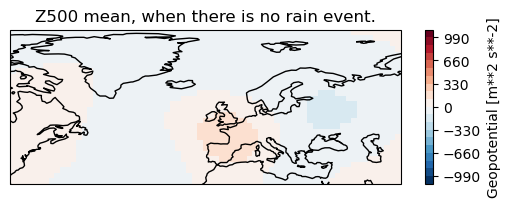

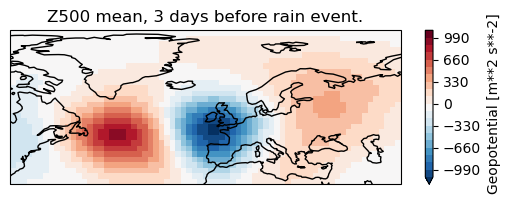

In [7]:
p=default_composites.myZ500.sel(lag=0,index_val=0).plot(levels=np.linspace(-1100,1100,21),\
    transform=ccrs.PlateCarree(),subplot_kws={'projection':ccrs.PlateCarree()})
p.axes.set_title('Z500 mean, when there is no rain event.')
p.axes.coastlines()
p.figure.set_figheight(2)
plt.figure()
p=default_composites.myZ500.sel(lag=-3,index_val=1).plot(levels=np.linspace(-1100,1100,21),\
    transform=ccrs.PlateCarree(),subplot_kws={'projection':ccrs.PlateCarree()})
p.axes.set_title('Z500 mean, 3 days before rain event.')
p.axes.coastlines()
p.figure.set_figheight(2)


Text(0.5, 1.0, 'Regime occurrence anomaly 5 days before rain event')

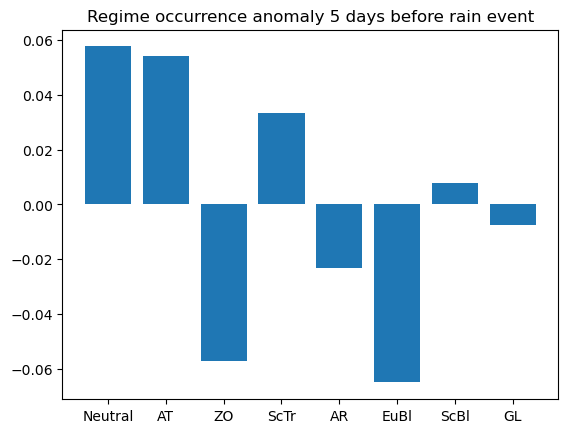

In [8]:
fig,ax=plt.subplots(1)
reg_names=default_composites.WR7.attrs['regime_labels']
ax.bar(reg_names,default_composites.WR7.sel(lag=-5,index_val=1).values)

ax.set_title('Regime occurrence anomaly 5 days before rain event')

### Sometimes it will be desirable to summarise variables corresponding to a given event using a different metric. For this reason *LaggedAnalyser.compute_composites* accepts the *con_func* and *cat_func* arguments, which set the function to be used for compositing for continuous and categorical variables respectively.

### For example, we may wish to look at the standard deviation of a variable, conditioned on an event, in order to assess whether the mean composite is smearing together multiple different signals. Domino contains a convenience function for this case already, *domino.agg.std_ds*, which we can use. Because it does not make sense to take a standard deviation of a categorical index, we set *cat_func*=None, which means categorical variables will be ignored. 

### To avoid overriding the default composites, which are currently stored internally as *analyser.composites*, we set *inplace*=False

In [9]:
std_composites=analyser.compute_composites(con_func=agg.std_ds,cat_func=None,inplace=False)

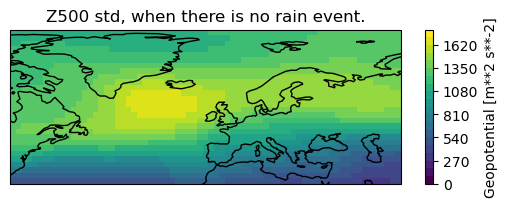

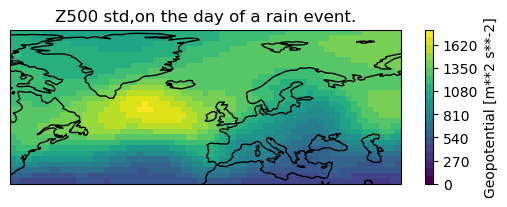

In [10]:
p=std_composites.myZ500.sel(lag=0,index_val=0).plot(levels=np.linspace(0,1800,21),\
    transform=ccrs.PlateCarree(),subplot_kws={'projection':ccrs.PlateCarree()})


p.axes.set_title('Z500 std, when there is no rain event.')
p.axes.coastlines()
p.figure.set_figheight(2)

plt.figure()
p=std_composites.myZ500.sel(lag=0,index_val=1).plot(levels=np.linspace(0,1800,21),\
    transform=ccrs.PlateCarree(),subplot_kws={'projection':ccrs.PlateCarree()})
p.axes.set_title('Z500 std,on the day of a rain event.')
p.axes.coastlines()
p.figure.set_figheight(2)

    


### It might be more convenient to look at anomalies of the standard deviation, rather than the absolute value. We can of course rerun our compute_composites() command, now with as_anomaly=True, but we can also do it ourselves using the *LaggedAnalyser.aggregate_variables* method.

### This applies a summary statistic just like *compute_composites* but without conditioning on the *event* index first

In [11]:
avrg_std=analyser.aggregate_variables(con_func=agg.std_ds,cat_func=None)

standardised_std_composites=(std_composites/avrg_std)

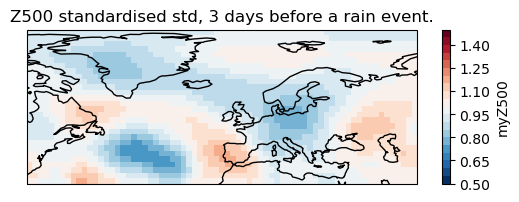

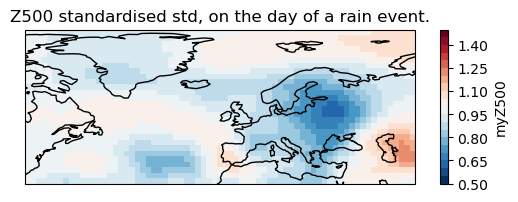

In [12]:
p=standardised_std_composites.myZ500.sel(lag=-3,index_val=1).plot(levels=np.linspace(0.5,1.5,21),\
    transform=ccrs.PlateCarree(),subplot_kws={'projection':ccrs.PlateCarree()},cmap='RdBu_r')


p.axes.set_title('Z500 standardised std, 3 days before a rain event.')
p.axes.coastlines()
p.figure.set_figheight(2)

plt.figure()
p=standardised_std_composites.myZ500.sel(lag=0,index_val=1).plot(levels=np.linspace(0.5,1.5,21),\
    transform=ccrs.PlateCarree(),subplot_kws={'projection':ccrs.PlateCarree()},cmap='RdBu_r')

p.axes.set_title('Z500 standardised std, on the day of a rain event.')
p.axes.coastlines()
p.figure.set_figheight(2)

    


### We are not limited to inbuilt summary metrics. Any function which takes an xarray.Dataset as input, and returns an xarray.Dataset is a valid summary function. As brief examples, we show how to compute median composites for continuous variables, and how the most likely category of a variable during an event can be obtained:

In [13]:
def median_ds(dataset,dim,*args):
    return dataset.median(dim=dim)
   
#This function, which operates on DataArrays, won't work as it is:
def mode_da(da,dim):
    axis=np.argwhere(np.array(da.dims)==dim)[0][0]
    k,n=np.unique(da,axis=axis,return_counts=True)
    return da.isel({dim:0}).copy(data=k[np.argmax(n)])

#But we can wrap it within Dataset.map, like this, to work for Datasets:
def mode_ds(ds,dim,*args):
    return ds.map(mode_da,dim=dim)
   
median_composite=analyser.compute_composites(con_func=median_ds,cat_func=None,inplace=False)
mode_composite=analyser.compute_composites(con_func=None,cat_func=mode_ds,inplace=False)

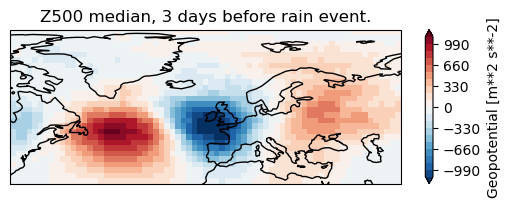

In [14]:
p=median_composite.myZ500.sel(lag=-3,index_val=1).plot(levels=np.linspace(-1100,1100,21),\
    transform=ccrs.PlateCarree(),subplot_kws={'projection':ccrs.PlateCarree()},cmap='RdBu_r')


p.axes.set_title('Z500 median, 3 days before rain event.')
p.axes.coastlines()
p.figure.set_figheight(2)


### Another useful method is *LaggedAnalyser.add_derived_composite()*. Sometimes we might want to composite a variable derived from one or more other variables. For example, say for some reason we wanted to look at the gradient of Z500.
### We could compute the gradient of the Z500 time series and add it as an additional variable to composite, but as it is a linear quantity we might as well compute the gradient of the Z500 composite, which will be both more CPU and memory efficient.
### *add_derived_composite* accepts a function which takes 1 or more DataArrays as input, and returns one DataArray. We tell *LaggedAnalyser* which variables to pass in to *func*, by passing their names, in order, via *composite_vars*:

In [15]:
def spherical_2d_grad(da):
    r=6.371*10**6
    sintheta=np.sin(np.deg2rad(da['lat']))
    #lat, lon
    grad=[da.differentiate('lat')/(r*sintheta),da.differentiate('lon')/r]
    return xr.concat(grad,'vector_component')
analyser.add_derived_composite(name='grad_Z',func=spherical_2d_grad,composite_vars=['myZ500'])

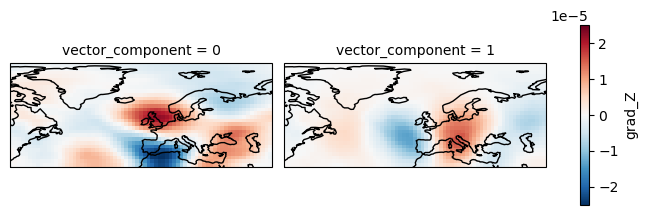

In [16]:
p=analyser.composites.grad_Z.sel(lag=0,index_val=1)\
    .plot(col='vector_component',transform=ccrs.PlateCarree(),subplot_kws={'projection':ccrs.PlateCarree()})
for a in p.axes.flat:
    a.coastlines()
p.fig.set_figheight(2)

### In addition to computing lagged composites of our variables, we would probably also like to be able to distinguish meaningful signals in our composites from sampling noise. *LaggedAnalyser* possesses several methods to assist with this.

### The simplest is *LaggedAnalyser.bootstrap_significance*, which produces a number of bootstrapped composites from synthetic event sequences, and then applies a 2-sided significance test for each feature of each variable in *LaggedAnalyser.composites*, returning True if the composite passes the test, and False otherwise:

##### N.B. All bootnums in this example script are quite small. While this makes the notebook run reasonably quickly, it would be wise to use larger bootnums (~400) for actual analyses

In [17]:
#This may take a moment to run
significance=analyser.bootstrap_significance(bootnum=40,p=0.05).load()

#### domino.plotting has some helpful functions for applying a Boolean mask to data:

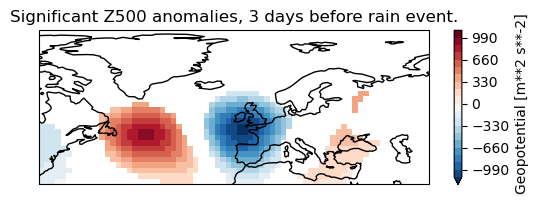

In [18]:
masked_composite=default_composites.where(significance)

p=masked_composite.myZ500.sel(lag=-3,index_val=1).plot(levels=np.linspace(-1100,1100,21),\
    transform=ccrs.PlateCarree(),subplot_kws={'projection':ccrs.PlateCarree()},cmap='RdBu_r')


p.axes.set_title('Significant Z500 anomalies, 3 days before rain event.')
p.axes.coastlines()
p.figure.set_figheight(2)

   

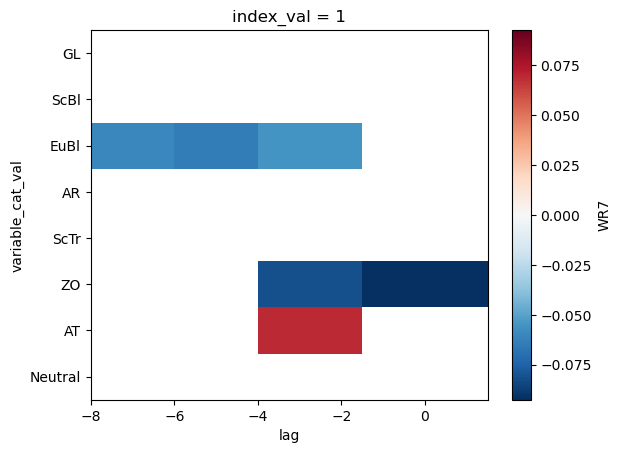

In [19]:
p=masked_composite.WR7.sel(index_val=1).T.plot()
p.axes.set_yticks(range(8))
p.axes.set_yticklabels(reg_names);

### Note that we have also computed significance for our derived *grad_Z* variable. *LaggedAnalyser* internally stores the rules for computing the derived variable, and can then apply it to each bootstrap composite.

### If we want to see in more detail what is going on inside *bootstrap_significance* or we wish to compute significance for composites not stored within *LaggedAnalyser*, we can use the *LaggedAnalyser.compute_bootstraps* and *LaggedAnalyser.get_significance* methods:

In [20]:
std_bootstraps=xr.concat([analyser.compute_bootstraps(bootnum=50,\
                con_func=agg.std_ds,cat_func=None,lag=l) for l in std_composites.lag.values],'lag')

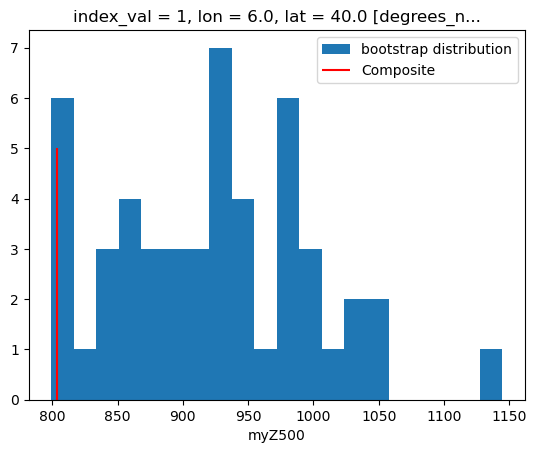

In [21]:
# Lets look at a specific gridpoint of myZ500, to see how the bootstrap significance testing works:
p=std_bootstraps.myZ500.sel(lag=0,index_val=1,lat=40,lon=6).plot.hist(bins=20,label='bootstrap distribution')
plt.gca().vlines(std_composites.myZ500.sel(lag=0,index_val=1,lat=40,lon=6).values,0,5,colors='r',label='Composite')
plt.legend()

In [22]:
std_significance=analyser.get_significance(std_bootstraps,std_composites,0.05,data_vars=['myZ500'])

In [23]:
masked_std_composites=standardised_std_composites.where(std_significance)

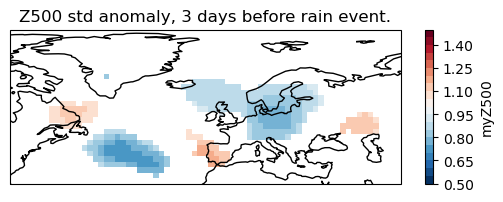

In [24]:
masked_composite=default_composites.where(significance)

p=masked_std_composites.myZ500.sel(lag=-3,index_val=1).plot(levels=np.linspace(0.5,1.5,21),\
    transform=ccrs.PlateCarree(),subplot_kws={'projection':ccrs.PlateCarree()},cmap='RdBu_r')


p.axes.set_title('Z500 std anomaly, 3 days before rain event.')
p.axes.coastlines()
p.figure.set_figheight(2)


### We can also reduce the rate of false positives in our significance test by applying a Holm-Bonferroni correction. Note that this is currently only applied to each variable independently:

In [25]:
std_significance_w_hb_correction=analyser.get_significance(std_bootstraps,std_composites,0.05,data_vars=['myZ500'],hb_correction=True)

In [26]:
masked_std_composites=standardised_std_composites.where(std_significance_w_hb_correction)

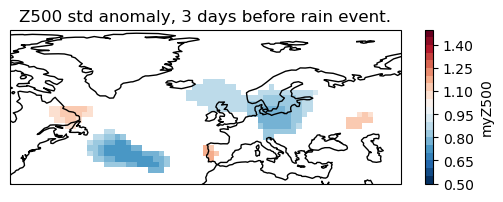

In [27]:
masked_composite=default_composites.where(significance)

p=masked_std_composites.myZ500.sel(lag=-3,index_val=1).plot(levels=np.linspace(0.5,1.5,21),\
    transform=ccrs.PlateCarree(),subplot_kws={'projection':ccrs.PlateCarree()},cmap='RdBu_r')


p.axes.set_title('Z500 std anomaly, 3 days before rain event.')
p.axes.coastlines()
p.figure.set_figheight(2)


### We see that the total unmasked area is now reduced.